## Unsupervised Learning – Principal Component Analysis

### Capstone Project: US Arrests Dataset

Bronwyn Bowles-King

### Introduction

The US Arrests dataset is well-known in statistics and data science. It shows the number of arrests per 100 000 residents in 1973 for murder, assault and rape crimes, as well as the percentage of the population in the urban areas in each of the 50 American states at the time. The data is originally from McNeil's (1977) book *Interactive Data Analysis*. It is useful for demonstrating techniques in multivariate analysis and clustering in Python and other programming languages (Cabezas, Izbicki & Stern, 2023; Ronci, 2024).

This notebook provides and explains the steps taken to conduct Principal Component Analysis (PCA) of the dataset with Python, including data cleaning and preparation, correlation analysis, running PCA using the sklearn function, visualising the results, and a comparison with alternative clustering techniques. The main goal is to determine the principal components (PC) that best capture patterns in the data. Identifying PCs simplifies complex data but retains the most relevant information (variance) and is useful for visualising data with many features or dimensions (HyperionDev, 2025; IBM, 2023). 

The US Arrests dataset also lends itself to exploration using techniques such as K-means and agglomerative hierarchical clustering. These methods can reveal patterns and groups in the PCA-transformed data that were not initially apparent. This could narrow down states into smaller groups with similar crime and demographic features in the 1970s. By combining dimension reduction with clustering, I will show that complex multivariate data can be summarised and interpreted visually and quantitatively more easily with PCA and dataset clustering. 

### 1. Preparation steps

#### 1.1 Load libraries and define functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings("always")

#### 1.2 Define functions

In [2]:
def display_table(df, caption, font_color="#395469"):
    """
    Displays dataframe as a styled table with heading in bold, 
    blue-grey font as default that can be changed. 
    Numbers are shown to two decimal places.

    Parameters:
    - df (pd.DataFrame): df to display
    - caption (str): Header text above the table
    - font_color (str): Header font colour (default blue-grey)
    """
    styles = [dict(
        selector="caption", props=[("font-weight", "bold"), ("color", font_color)]
    )]
    
    display(
        df.style
            .format(precision=2)
            .set_caption(caption)
            .set_table_styles(styles)
    )


def plot_histograms(df, columns, color, title=None):

    """
    Create histograms for columns of dataframe with basic formatting.

    Arguments:
    - df (pd.DataFrame)
    - columns as a list to plot
    - color (str) as color code or name for histogram bars
    - title to appear at the top of the histograms
    """

    axs = df[columns].hist(
        color=color, grid=False, edgecolor='white', figsize=(10, 8)
    )
    for ax in axs.flatten():
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    plt.suptitle(title, fontsize=13)
    plt.show()


def plot_corr_map(dataframe, cmap='Greys', title=None):

    """
    Plot correlation map in a square with tight layout using 
    seaborn heatmap function. Ignores non-numerical data if present.

    Arguments:
    - dataframe: pd.DataFrame with numerical features to correlate
    - cmap: str for colour map. Defaults to grey palette
    - title: str for plot title
    """
    
    corr = dataframe.corr(numeric_only=True)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        corr,
        cmap=cmap,
        annot=True,
        square=True
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()


def hierarchical_clustering(
    df, 
    method=None, 
    metric=None, 
    labels=None, 
    title=None, 
    xlabel=None, 
    ylabel=None,
    cut_height=None):
    
    """        
    Performs hierarchical clustering and plots dendrogram to visualise 
    groups.

    Parameters:
    - df pd.DataFrame or np.ndarray: Data to cluster (numeric features)
    - method (str): Linkage method ('ward', 'complete', 'single')
    - metric (str): Distance metric ('euclidean', 'cityblock')
    - labels (array): Labels for the dendrogram leaves
    - title (str): Title for figure
    - xlabel and ylabel (str): Labels for axes
    - cut_height (float, optional): Dashed line at y-value specified shows 
    pruning threshold
    """
            
    Z = linkage(df, method=method, metric=metric)

    plt.figure(figsize=(7, 5))

    if cut_height is not None:
        plt.axhline(
            y=cut_height, 
            color='black', 
            linestyle='--', 
            label=f'Cut height: {cut_height}'
        )
        plt.legend()

    dendrogram(Z, labels=labels, leaf_rotation=90)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

#### 1.3 Load and preview dataset

The dataset is loaded as a pandas DataFrame. The preview in Table 1 shows that there are five columns besides the index and all of them are numerical except the column 'City'. However, this column is a list of US states and not cities, so this will be corrected in one of the steps below.

In [3]:
try:
    df = pd.read_csv('UsArrests.csv', index_col=False)
    print("Dataset successfully loaded")
    display_table(df.head(), "Table 1: Full unprocessed dataset")

except FileNotFoundError:
    print('File not found. Check directory.')

Dataset successfully loaded


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60


#### 1.4 Check for missing data and duplicates

All the columns contain 50 non-null entries, showing that no data is missing. The check for duplicate rows also found none.

In [4]:
print(df.info())

print(f'\nDuplicate rows: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None

Duplicate rows: 0


#### 1.5 Correct and organise the dataframe for PCA

The column 'City' is renamed 'State' and this dataframe (Table 2), which has all five columns, is saved simply as 'df', as it will be needed later in the analysis. 

Then, the non-numerical column 'State' is dropped from the dataframe as only numerical data is needed for PCA. Finally, the columns are rearranged so that the data on arrests by type of crime is together in the first three columns, and the data on urban population is in the last column. The new dataframe is named 'df_arrests' (Table 3). 

In [5]:
df = df.rename(columns={"City": "State"})

display_table(
    df.head(), 
    "Table 2: Full dataset with states included (df)"
)

try:
    df_arrests = df.drop("State", axis=1)
    print("Column removed.")
except KeyError:
    print("Column previously removed.")

df_arrests = df_arrests[['Murder', 'Assault', 'Rape', 'UrbanPop']]

display_table(
    df_arrests.head(), 
    "Table 3: Numerical columns only (rearranged) (df_arrests)"
)

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60


Column removed.


,Murder,Assault,Rape,UrbanPop
0,13.20,236,21.20,58
1,10.00,263,44.50,48
2,8.10,294,31.00,80
3,8.80,190,19.50,50
4,9.00,276,40.60,91


### 2. View summary statistics

In [6]:
display_table(
    df_arrests.describe(), 
    "Table 4: Summary statistics for US Arrests dataset"
)

,Murder,Assault,Rape,UrbanPop
count,50.00,50.00,50.00,50.00
mean,7.79,170.76,21.23,65.54
std,4.36,83.34,9.37,14.47
min,0.80,45.00,7.30,32.00
25%,4.08,109.00,15.07,54.50
50%,7.25,159.00,20.10,66.00
75%,11.25,249.00,26.18,77.75
max,17.40,337.00,46.00,91.00


### 3. Univariate histograms

The four histograms show the distributions of the main features: murder (Figure 1a), assault (1b) and rape (1c) arrests per 100 000 people in urban areas in the relevant state, and the urban population (1d). The urban population is the number of residents in general and is not an indication of total arrests or number of (convicted) criminals. The histograms are interpreted below with reference to the summary statistics in Table f above.

Figure 1a shows that the distribution for the murder rate per 100 000 people is right-skewed. Thus, most states had under 10 murder-related arrests for 100 000 people in 1973, but some have higher rates (up to about 17 arrests per 100 000).

For arrests for assault, Figure 1b shows a slightly more even distribution than for murder, but there is a moderate right skew. The states mostly had between 50 and 170 assaults per 100 000 residents, while the remainder show considerably higher assault rates (up to about 340).

The histogram showing the data distribution for rape is similarly right-skewed (Figure 1c). Most states were seeing between 8 and 25 arrests for rape, and a few states have unusually high rates of between 30 and 46 per 100 000 residents. 

These arrest rates all show a tendency for most states to have lower rates, with a smaller group experiencing very high rates. This could be related to urban population size, as suggested by its inclusion in this dataset, but there are other contributing factors.

The urban population percentage (Figure 1d) has some features of the bell curve or normal distribution, but with some important differences. There is a short left tail because very few states had an urban population size of under 45% in 1973. This is assumedly in comparison to the rural population, which is thus larger (55% or more) in these instances.

Most states are spread across a wide range for their urban population size from about 45% to 91%, and there is no particularly dominant cluster due to the similarity of the histogram to a bell curve. This reflects the varying nature of the states in the US, as a large country that has always had a fairly diverse demography and geography across the 50 states. In other words, there are states that are more agrarian, with large rural areas and populations, as well as states dominated more by urban areas and lifestyles. 

The inclusion of urban population in the dataset reflects the importance of population concentration in understanding crime rates. This variable could be important for PCA, as it may explain some of the variance in the data.

Overall, the differing histogram shapes for Figure 1a to 1c compared to Figure 1d suggest that violent crime rates are generally more variable across states and less uniformly distributed than urbanisation.


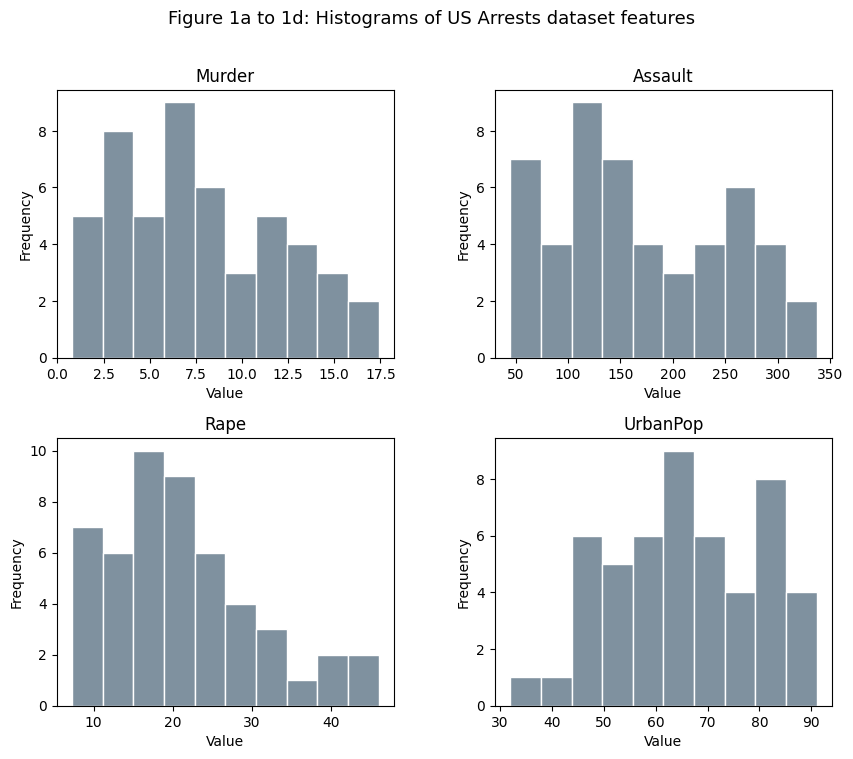

In [7]:
plot_histograms(
    df_arrests, 
    ['Murder', 'Assault', 'Rape', 'UrbanPop'], 
    color="#7f919f", 
    title='Figure 1a to 1d: Histograms of US Arrests dataset features'
)

### 4. Correlation map

The correlation map in Figure 2 shows stronger correlations in darker colours and smaller correlations in lighter colours. However, the black blocks along the diagonal can be ignored because these features are correlated with themselves. 

Assault and murder arrest rates are the most strongly correlated features (0.8), possibly because they are similar in nature or have related outcomes, i.e. serious harm to a person. The association is very strong and the two features together might be valuable in distinguishing states. 

There is also considerable correlation between rape and assault (0.67) and rape and murder (0.56), also likely because these crimes are committed at the same time by one person and so they are often charged with both. Rape is more strongly correlated with assault than with murder, but the difference is concerningly small. The correlation of urban population with rape (0.41) is somewhat notable, as it seems there is some level of connection between greater urbanisation and rape arrests. 

Urban population and assault arrests, and urban population and murder arrests, are the most weakly correlated factors. The very low correlation between murder and urban population (0.07) is surprising and means there is almost no linear relationship between the murder rate and the proportion of urban populations across US states in this dataset. Therefore, the urban vs rural population size does not seem to affect how many murder arrests were occurring in the early 1970s. Urban population size is also not strongly correlated with assault arrests (0.26), but the connection seems to be considerably stronger compared to murder. 

As there are no negative correlations shown, we can assume that as values for one feature increases, so do the others - although at widely different rates. The rates for assault and murder arrests rise or fall most readily together across states, but there is little correlation between increases and decreases in urban population and murder arrests in this dataset.

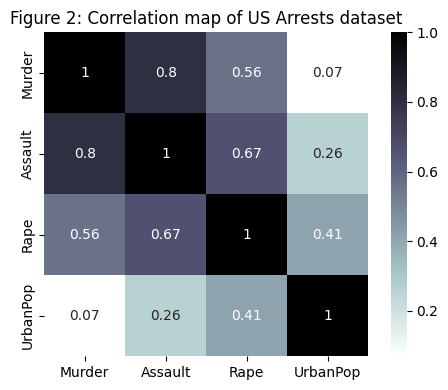

In [8]:
plot_corr_map(
    df_arrests, 
    cmap='bone_r',
    title='Figure 2: Correlation map of US Arrests dataset'
)

### 5. Standardise the data, fit and transform with PCA

The key features are now assigned to the X variable, which includes all numerical columns and excludes the names of the states. The sklearn functions for standardisation and PCA are applied to fit and transform the data. 

The data is scaled with StandardScaler because PCA is sensitive to the scale of each feature. Scaling ensures each feature contributes equally and the different measurement units in the dataset (arrests per 100 000 people and percentage of the population in urban areas) do not bias the results. PCA is then run without setting n_components, in which case the algorithm will use the number of features (columns), which is four for this parameter. This is done to allow the program to explore all the available data. 

A new dataframe with the PCA results is created ('pca_df'). The 'State' column is added back to it to compare the data with the original labels. The first few rows of the new dataframe are shown in Table 5. PC1 to PC4 values are shown as central components of the dataset. These components are new in the sense that they are a mixture of the original four features. PC1 and PC2 are the most important as they relate to the greatest divergence in the dataset and they will be used to plot the data in the next section. 

In [9]:
X = df_arrests

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca, 
    columns=['PC1', 'PC2', 'PC3', 'PC4']
)

pca_df['State'] = df['State']

display_table(
    pca_df.head(), 
    "Table 5: PCA results by state (first few rows) (pca_df)"
)

,PC1,PC2,PC3,PC4,State
0,0.99,-1.13,-0.44,-0.16,Alabama
1,1.95,-1.07,2.04,0.44,Alaska
2,1.76,0.75,0.05,0.83,Arizona
3,-0.14,-1.12,0.11,0.18,Arkansas
4,2.52,1.54,0.60,0.34,California


### 6. PCA biplot

A PCA biplot is created using code adapted from a function from Geeks for Geeks (2025). The biplot summarises the structure of the data and the loadings of each variable. Loadings are coefficients or weights indicating how much features contribute to the PCs. The first and second PC scores (xs and ys) are extracted from the 'pca_df' dataframe for plotting on the x- and y-axis in Figure 3. 

The green arrows extend from the origin of the plot (0, 0) and indicate how strongly and in what direction each original feature contributes to the first two PCs. The arrows thus show the contributions of the murder, assault and rape arrest rates and urban population levels to the two main PCs. The longer arrow for urban population shows that this feature has a stronger influence on the PCs. 

The direction of each arrow shows how much a feature increases with higher PC values. The arrows for murder and assault arrest rates point in a similar direction, showing these features generally increase together and could help distinguish states. The arrest rates for all three crime types generally point towards the right, suggesting they are positively correlated and strongly contribute to the separation among states along PC1 on the x-axis. However, the urban population arrow points more upwards than any of the others, showing how it is more strongly associated with PC2 on the y-axis.

Each grey dot represents an American state. The points are positioned according to their scores for PC1 and PC2 (the axes of greatest variance in the data) (IBM, 2023). There are no large or tight clusterings among the states on this graph, but there is one small overlapping cluster that includes Utah and Massachusetts, with Rhode Island and Hawaii nearby. Generally, however, there is considerable spread, reflective of the diverse nature of the US. 

Although there are few states positioned very tightly together, the nearness of two points does indicate that certain states exhibit similar patterns of crime and urban population size (relative to rural population), while those far apart differ substantially. For instance, states in the upper right quadrant, like New York and Colorado, have higher urban populations and arrest rates. Those in the lower left, such as Vermont and North Dakota, have lower urban populations and arrest rates. 

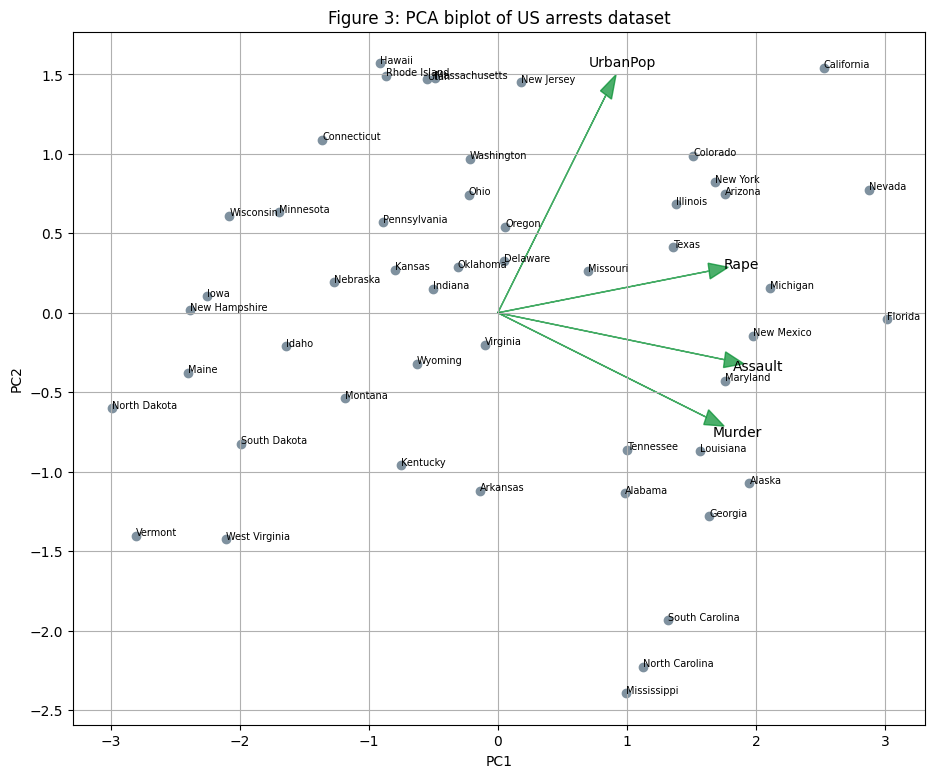

In [10]:
xs = pca_df['PC1'].values
ys = pca_df['PC2'].values
states = pca_df['State'].values 
loadings = pca.components_.T  
feature_names = ['Murder', 'Assault', 'Rape', 'UrbanPop']  

plt.figure(figsize=(11, 9))
plt.scatter(xs, ys, color="#7f919f")

for i, state in enumerate(states):
    plt.text(xs[i], ys[i], state, fontsize=7)

for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0]*max(xs), loadings[i, 1]*max(ys), 
              color="#008d2d", alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*max(xs)*1.15, loadings[i, 1]*max(ys)*1.15, 
             feature, color='black', fontsize=10, ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Figure 3: PCA biplot of US arrests dataset')
plt.grid(True)
plt.show()

### 7. Determine the number of principal components to retain: Scree and cumulative explained variance plots 

Selecting how many components to keep in PCA can be done with a scree (simple explained variance) plot and cumulative explained variance plot. Each PC explains a certain proportion of the dataset's total variance. Enough PCs are chosen that together explain a sufficiently high proportion of the variance so that less relevant data can be set aside and data modelling can be simplified.  

The two plots below were made using code adapted from Ahmed (2025). The scree plot in Figure 4 displays the proportion of variance (y-axis) explained by each PC (x-axis) individually. The values plotted in the figures can be seen below the figures. We can see that PC1 accounts for the largest variance because it corresponds to the highest point on the y-axis (0.62). PC2 explains a smaller but still considerable proportion of the variance (0.25). 

Together, PC1 and PC2 account for 0.87 of the variance. The cumulative values plotted in Figure 5 reflect this high proportion of explained variance, with the elbow starting to curve at PC2, but not making a significant increase thereafter. 

PC3 and PC4 together only account for a slight additional proportion of the variance (0.11). This is reflected in the rapid decline after PC2 towards PC3 and PC4 in Figure 4. Figure 5 also shows that the cumulative variance increases very little as we move beyond PC2. 

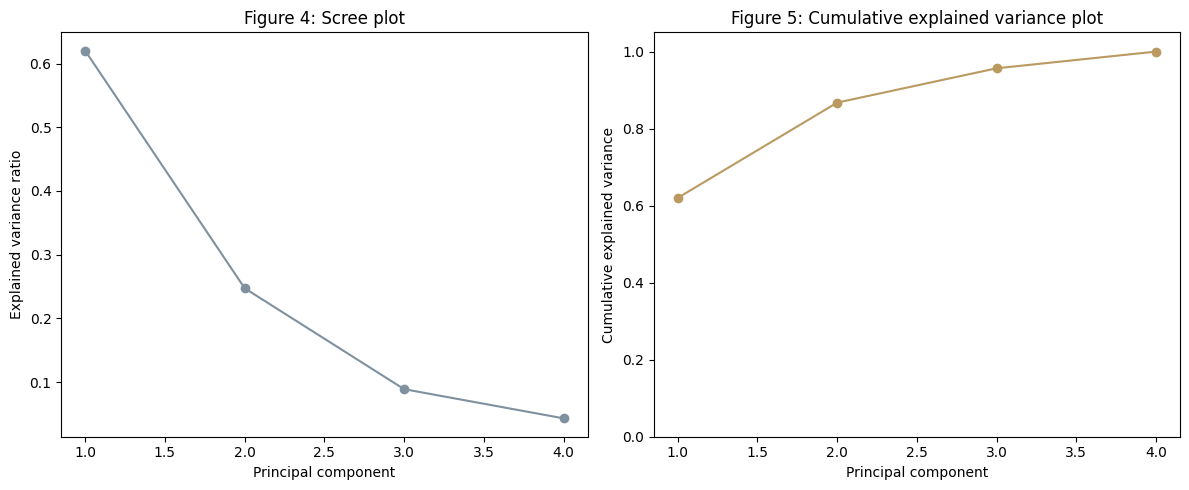

Figure 4 - Explained variance values for PC1 to PC4: 0.62, 0.25, 0.09, 0.04
Figure 5 - Cumulative explained variance as PCs are added (1 to 4): 0.62, 0.87, 0.96, 1.00


In [11]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(12, 5))

# Scree plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 
        marker='o', color='#7f919f')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Figure 4: Scree plot')

# Cumulative explained variance plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
        marker='o', color="#ba9a60")
plt.xlabel('Principal component')
plt.ylabel('Cumulative explained variance')
plt.title('Figure 5: Cumulative explained variance plot')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

ev_values = [f"{val:.2f}" for val in explained_variance]
print(
    f"Figure 4 - Explained variance values for PC1 to PC4: {', '.join(ev_values)}"
)

cev_values = [f"{val:.2f}" for val in cumulative_variance]
print(
    f"Figure 5 - Cumulative explained variance as PCs are added (1 to 4): {', '.join(cev_values)}"
)

It is acceptable to remove PC3 and PC4 because they have diminishing returns and the majority of the meaningful data is captured by PC1 and PC2. Therefore, PC3 and P4 are dropped from the dataframe, and the new dataframe ('pca_transformed') is created containing only PC1 and PC2 values to use going forward. 

In [12]:
pca_transformed = pca_df.drop(["PC3", "PC4", "State"], axis=1)

display_table(
    pca_transformed.head(), 
    "Table 6: PC1 and PC2 (first few rows) (pca_transformed)"
)

,PC1,PC2
0,0.99,-1.13
1,1.95,-1.07
2,1.76,0.75
3,-0.14,-1.12
4,2.52,1.54


### 7. K-means clustering 

#### 7.1 Determine the number of clusters

The plotting code below is adapted from Saji (2025). It performs K-means clustering on the new PCA dataset (pca_transformed) using PC1 and PC2 only for a range of values (k) from 2 to 7. As with the scree and cumulative explained variance plot above, we are looking for the elbow of the curve before an increase in the number of clusters (k) leads to diminishing returns in the explained variance. 

On the y-axis, Figure 6 shows the within-cluster sum of squares (WCSS), a measure of the homogeneity or compactness of a cluster. Each k value tested for WCSS is shown on the x-axis. A lower WCSS is generally desirable as it indicates that the data points within each cluster are more similar to each other, and so the clusters are well-defined (Tiamiyu, 2023). 

However, a WCSS that is too low is not preferable either as this results in overfitting and poor interpretability. If the clusters are too small, they create noise or reflect only very minor differences rather than meaningful groups. This is why the elbow plot is useful to find the most balanced value for k. WCSS is also called 'inertia' (Dobilas, 2021).

Based on the elbow plot in Figure 6, as well as the biplot in Figure 3, four clusters are chosen for K-means clustering. The biplot above was also considered because of how points on the graph which represent American states are considerably scattered across all four quadrants of the graph. It seems prudent to allow the clustering algorithm to detect these four general groupings which represent the four possible combinations of high or low arrest rates with high or low urban population rates. 

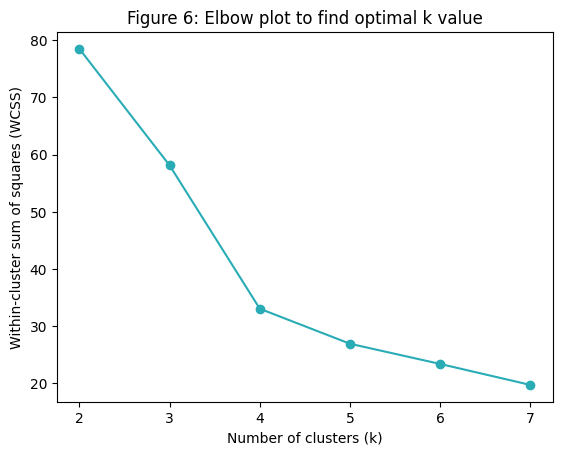

In [13]:
wcss = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_transformed)  
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 8), wcss, marker='o', color='#29acb5')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Figure 6: Elbow plot to find optimal k value')
plt.show()

#### 7.2 K-means plot for four clusters

The plotting code below is adapted from VanderPlas (2023). It creates a figure showing the four clusters ('Cluster_4') of American states by arrests and urban population size in 1973 based on PC1 and PC2. The cluster assignments in 'Cluster_4' are also added to the 'pca_df' dataframe. 

The centre of each cluster is identified by an x in Figure 7. The general directions of the green arrows, which represent urban population and arrest rate increases, should be borne in mind. The urban population arrow points towards the top right, indicating states with higher urban population sizes. The arrows for the three arrest types show higher rates for states toward the right of the plot. 

Therefore, the black clusters represent the states that have higher urban populations as well as higher arrest rates, such as California, and thus likely more crime in general, compared to the other states in the sample. This cluster appears well-defined and the same can be said of the other clusters. The brown cluster indicates states such as Washington that have high urban populations yet low arrest rates compared to those indicated in black.

The cluster of grey points indicates states with lower urban population rates, making them more rural or agrarian, combined with fewer criminal arrests, such as Maine. Blue cluster states, like Alabama, are those that also have a relatively low urban population size, but with a higher arrest rate. 

It is also possible to cluster the states into five groups and a figure showing this is found at the end of this notebook in the appendix. With five clusters, states with more moderate populations in urban areas and moderate arrest rates relative to the others are distinguishable from the four groups described based on Figure 7. These states include Virginia and Indiana. Hierarchical agglomerative clustering conducted in the next section will also reveal a five-cluster structure. However, I have kept the figure below with four clusters for comparative purposes with the dendrograms to follow.

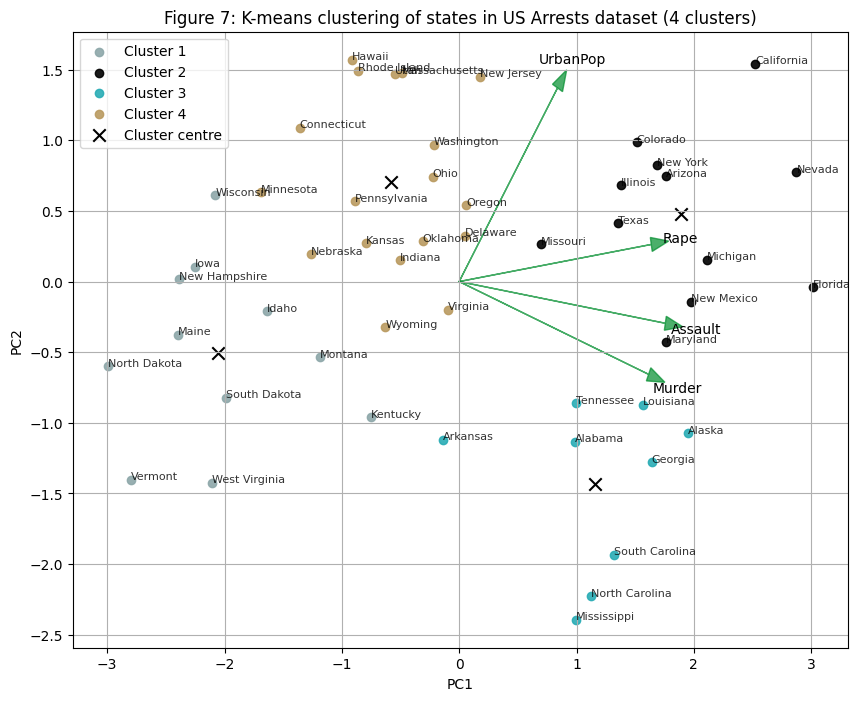

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_transformed)

pca_df['Cluster_4'] = clusters

plt.figure(figsize=(10, 8))

colors = [
        "#8da7a9", 
        "#000000", 
        "#29acb5", 
        "#ba9a60"
]

for clust in range(4):
    group = pca_df[pca_df['Cluster_4'] == clust]
    plt.scatter(group['PC1'], group['PC2'],
                color=colors[clust], label=f'Cluster {clust+1}', alpha=0.9)
    # Add state names
    for _, row in group.iterrows():
        plt.text(row['PC1'], row['PC2'], row['State'], fontsize=8, alpha=0.8)

for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0]*max(xs), loadings[i, 1]*max(ys), 
              color="#008d2d", alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*max(xs)*1.15, loadings[i, 1]*max(ys)*1.15, 
             feature, color='black', fontsize=10, ha='center', va='center')
    
centres = kmeans.cluster_centers_
plt.scatter(centres[:, 0], centres[:, 1], 
            marker='x', color='black', s=80, label='Cluster centre')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(
    'Figure 7: K-means clustering of states in US Arrests dataset (4 clusters)'
)
plt.legend()
plt.grid(True)
plt.show()

### 8. Hierarchical agglomerative clustering 

#### 8.1 Euclidean metric and Ward linkage method

Hierarchical agglomerative (or bottom-up) clustering places data points into groups starting from the most granular level and then merging the most similar clusters in steps. The PCA-transformed data is used here. No specific number of clusters is needed ahead of time with this approach. 

Based on this clustering approach and different splitting methods and distance metrics (the model parameters), two dendrograms are plotted below with code from various sources, including Chia (2025) and MathWorks (n.d.). Various parameter combinations were plotted initially and the options that show the clearest groups were chosen. The dendograms visualise and help us choose the number of clusters based on how well defined the groups are by the hierarchical clustering algorithm.

The Euclidean metric and Ward linkage method were combined to plot the dendrogram in Figure 8. It is worth noting that Ward's method can only be applied with the Euclidean metric and no other combination works for this method. The city block (Manhattan) metric is also then used with the complete linkage method for Figure 9. This allows us to see a number of different ways that the data can be split based on two related but slightly different clustering approaches. Other method and metric combinations are possible, but the figures are very much the same as the ones chosen below, so that it is not necessary to show them all.

The Euclidean metric and Ward linkage work well together as they create balanced clustering for continuous variables like the US Arrests dataset. It is often considered a good default approach to begin with when working with standardised, PCA data (Anselin, 2020). The Euclidean metric and Ward linkage together merge clusters so that within-cluster variance is minimised, making the datapoints in each group more reliably similar. This approach thus favours compact and homogeneous groups. 

However, when compared with Figure 9 below and the data for each state, as depicted in Figure 7, there is an advantage to considering hierarchical clustering with complete linkage and the city block metric. Figure 9 distinguishes better between the clusters indicated in green and red, whereas Figure 8 shows them only in green. We will see how this is relevant in the next section.

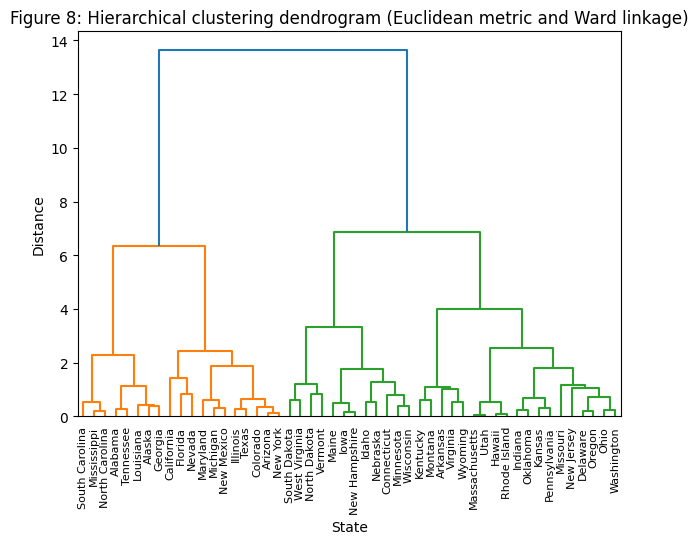

In [15]:
hierarchical_clustering(
    pca_transformed, 
    method='ward', 
    metric='euclidean', 
    labels=pca_df['State'].values, 
    title=
    'Figure 8: Hierarchical clustering dendrogram (Euclidean metric and Ward linkage)',
    xlabel='State', 
    ylabel='Distance'
)

#### 8.2 City block metric and complete linkage method

In Figure 9 below, the dendrogram forms large branches that separate states into five groupings towards the bottom of the graph around the 4-unit distance mark. The units for 'distance' shown on the y-axis are a measure of higher or lower dissimilarity and are based on standard deviations or another mathematical metric between the PCA data (Chia, 2025). At the 5-unit distance mark, these are merged into four groups, and so on as we move up the tree. 

The tree can be 'pruned' to select the number of clusters where the clusters are most far apart based on the vertical line that represents the longest distance (greatest dissimilarity) between clusters, often revealing the most substantial groupings. The clusters could be split higher up into four large groups, or slightly lower down into five groups. Five groups can be more informative and so these will be considered going forward, as shown by the cut height of 4. The groups can be compared to the K-means clusters and PCA arrows in Figure 7. 

The first orange group contains mostly states with higher urban populations yet lower arrest rates. This first orange group contains mostly southern states, such as Alabama, and corresponds with the blue cluster in Figure 7. 

The second orange group on the left corresponds to states with high urban population levels and higher arrest rates, such as California. This higher-crime cluster is a mix of more urbanised states from across America and is also mostly found in the black cluster in Figure 7. All the orange groups are similar in that they have higher urban populations.

The green group in the centre contains states with lower urban population and lower arrest rates generally, and so it makes sense that they are separate from the high-arrest and high-population groups. These states include Maine and correspond to the grey cluster in Figure 7. 

The first red cluster is an interesting group that corresponds with states positioned more towards the centre of the scatterplot in Figure 7 above. These states tend to have more moderate arrest and urban population rates, and it is good that the method applied here has picked this up. Some of these states are Virginia and Indiana and they correspond mostly to the brown cluster in Figure 7, as well as a few of the grey points. Figure 9 thus better separates this group visually from states on the outer extremes in terms of urban population and arrest levels.

The last red group of states is very mixed, coming from across the country and overseas (Hawaii). All these states have lower arrest but higher urban population rates, corresponding mostly to the brown cluster in Figure 7. Considering that the first red group has more moderate features, but the second red group has a mix of lower arrests and larger urban populations, it would make sense to keep them apart.

Overall, the clusters in Figure 9 correspond with the K-means scatterplot and PCA results, while also pointing to those states that have moderate arrest rates and urban population sizes.

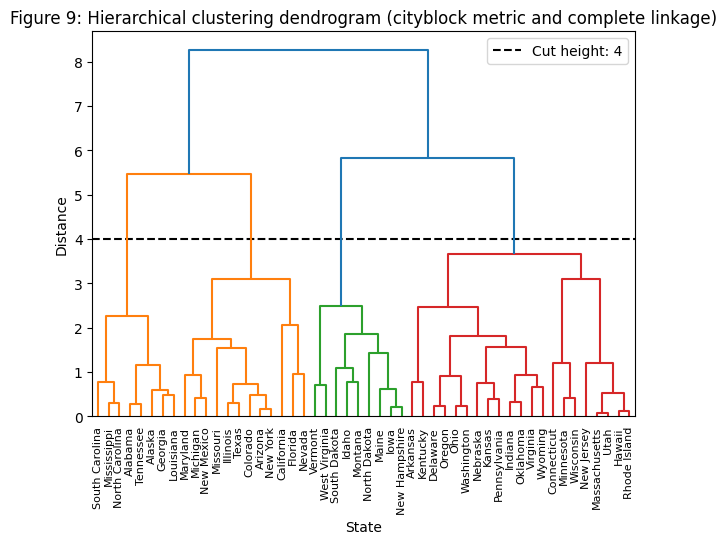

In [16]:
hierarchical_clustering(
    pca_transformed, 
    method='complete', 
    metric='cityblock', 
    labels=pca_df['State'].values, 
    title=
    'Figure 9: Hierarchical clustering dendrogram (cityblock metric and complete linkage)',
    xlabel='State', 
    ylabel='Distance',
    cut_height=4
)

### Conclusion

My notebook here demonstrates how the unsupervised learning methods PCA, K-means and hierarchical clustering can uncover meaningful patterns in the US Arrests dataset. By reducing the dataset to two principal components, it is still possible to visualise and interpret the complex relationships between crime or arrest rates and urbanisation across America in 1973. 

Relying on only two new features derived from PCA, K-means and hierarchical clustering revealed distinct groups of states that share similar arrest levels and population distributions. The results illustrate the value of combining dimensionality reduction with clustering for exploratory analysis. These techniques provide a foundation for further investigations or for informing understandings of socio-demographic trends.

### References

Ahmed, S. (2025). Principal Component Analysis (PCA) Made Easy: A Complete Hands-On Guide. Medium. https://medium.com/@sahin.samia/principal-component-analysis-pca-made-easy-a-complete-hands-on-guide-e26a3680c0bc
 
Anselin, L. (2020). Cluster Analysis (2): Hierarchical Clustering Methods. GeoDa Centre. https://geodacenter.github.io/workbook/7bh_clusters_2a/lab7bh.html

Cabezas, L.M., Izbicki, R., & Stern, R.B. (2023). Hierarchical clustering: Visualization, feature importance and model selection. *Applied Soft Computing*, 141, 110303.

Chia, A. (2025). Hierarchical Clustering: Concept Overview With Examples. DataCamp. https://www.datacamp.com/tutorial/hierarchical-clustering

Data Scientyst. (2022). How to Set Caption and Customize Font Size and Color in Pandas DataFrame. https://datascientyst.com/set-caption-customize-font-size-color-in-pandas-dataframe

Dobilas, S. (2021). K-Means Clustering - A Comprehensive Guide to Its Successful Use in Python. Towards Data Science. https://towardsdatascience.com/k-means-clustering-a-comprehensive-guide-to-its-successful-use-in-python-c3893957667d

Geeks for Geeks. (2025). Feature Importance in PCA: Analyzing Loadings and Biplots. https://www.geeksforgeeks.org/machine-learning/feature-importance-in-pca-analyzing-loadings-and-biplots

HyperionDev. (2025). Unsupervised Learning – Principal Component Analysis. Course materials. Private repository, GitHub.

IBM. (2023). What is principal component analysis (PCA)? https://www.ibm.com/think/topics/principal-component-analysis

Jolliffe, I.T., & Cadima, J. (2016). Principal component analysis: a review and recent developments. *Philosophical Transactions Series A, Mathematical, physical, and engineering sciences*, 374(2065), 20150202. https://doi.org/10.1098/rsta.2015.0202

MathWorks. (n.d.). linkage. https://www.mathworks.com/help/stats/linkage.html

McNeil, D.R. (1977). *Interactive Data Analysis*. New York: Wiley.

Ronci, G. (2024). Clustering USArrests Dataset using K-means Method. LinkedIn. https://www.linkedin.com/pulse/clustering-usarrests-dataset-using-k-means-method-giancarlo-ronci-xga2f

Sachinsoni (2023). Mastering Hierarchical Clustering: From Basic to Advanced. Medium. https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93

Saji, B. (2025). Elbow Method for Optimal Cluster Number in K-Means. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning

scikit-learn. (2025). AgglomerativeClustering. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

scikit-learn. (2025). KMeans. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

scikit-learn. (2025). PCA. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

scikit-learn. (2025). Principal Component Analysis (PCA) on Iris Dataset. https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

SciPy. (2008). Hierarchical clustering. https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

Tiamiyu, I. (2023). Clustering: WCSS and Elbow method. Medium. https://medium.com/@tiami.abiola/clustering-wcss-and-elbow-method-427db8968ba1

VanderPlas, J. (2023). In Depth: k-Means Clustering. GitHub. https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

Wikipedia. (2005). Map of USA with state names. https://en.m.wikipedia.org/wiki/File:Map_of_USA_with_state_names.svg

#### Appendix: K-means plot for five clusters and final dataframe

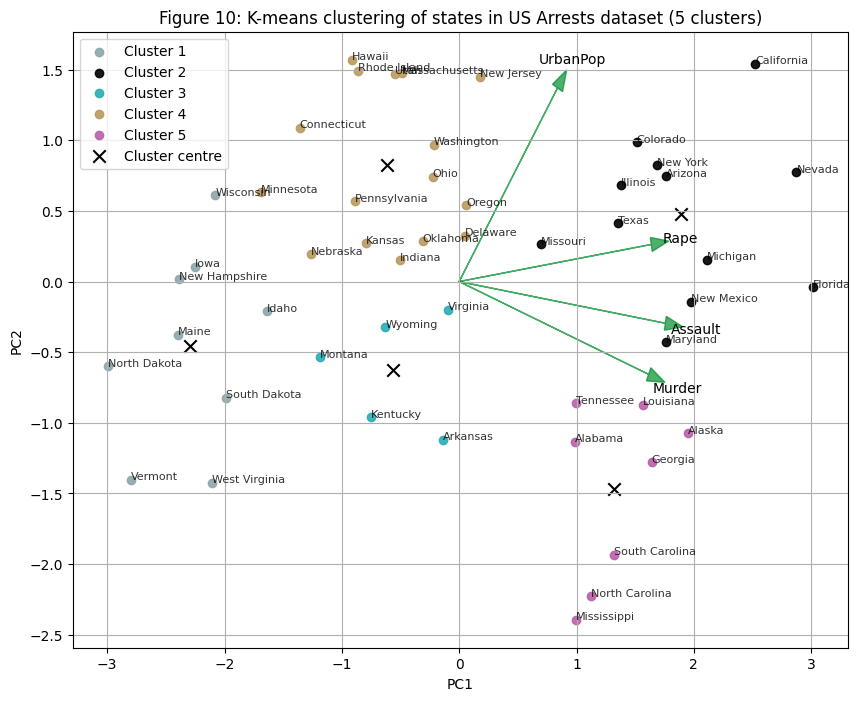

In [17]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_transformed)

pca_df['Cluster_5'] = clusters

plt.figure(figsize=(10, 8))

colors = ["#8da7a9", "#000000", "#29acb5", "#ba9a60", "#ba60a8"]

for clust in range(5):
    group = pca_df[pca_df['Cluster_5'] == clust]
    plt.scatter(group['PC1'], group['PC2'],
                color=colors[clust], label=f'Cluster {clust+1}', alpha=0.9)
    for _, row in group.iterrows():
        plt.text(row['PC1'], row['PC2'], row['State'], fontsize=8, alpha=0.8)

for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0]*max(xs), loadings[i, 1]*max(ys), 
              color="#008d2d", alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*max(xs)*1.15, loadings[i, 1]*max(ys)*1.15, 
             feature, color='black', fontsize=10, ha='center', va='center')
    
centres = kmeans.cluster_centers_

plt.scatter(centres[:, 0], centres[:, 1], 
            marker='x', color='black', s=80, label='Cluster centre')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(
    'Figure 10: K-means clustering of states in US Arrests dataset (5 clusters)'
)
plt.legend()
plt.grid(True)
plt.show()


In [19]:
display_table(
    pca_df.head(), 
    "Table 7: Final dataset - PCA values and clusters by state (first few rows) (pca_df)"
)

,PC1,PC2,PC3,PC4,State,Cluster_4,Cluster_5
0,0.99,-1.13,-0.44,-0.16,Alabama,2,4
1,1.95,-1.07,2.04,0.44,Alaska,2,4
2,1.76,0.75,0.05,0.83,Arizona,1,1
3,-0.14,-1.12,0.11,0.18,Arkansas,2,2
4,2.52,1.54,0.60,0.34,California,1,1
